In [1]:
import torch
from torch.autograd import Variable
import os
import torch.nn as nn
from datetime import datetime
from ResUNet import ResUNet
from dataloader import IDRiD_Dataset
import torch.nn.functional as F
import numpy as np
import logging
import time
import random
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import csv
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
segmentation_dir = './dataset/1. Original Images/a. Training Set'
mask_dir = './dataset/2. All Segmentation Groundtruths/a. Training Set'
image_dir = './classification_dataset/1. Original Images/a. Training Set'
csv_dir = './classification_dataset/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'

dataset = IDRiD_Dataset(
    image_root=image_dir,
    csv_path=csv_dir,
    mask_root=mask_dir,
    trainsize=224,
    augmentations=True,
    mask_type='multichannel'
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

Using augmentations


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
def train_classification_only(model, train_loader, val_loader, epochs, device, log_dir='logs'):
    set_seed(42)
    cls_loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    
    os.makedirs(log_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f'cls_train_log_{timestamp}.csv')
    
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'val_loss', 'accuracy'])

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        correct = 0
        total = 0

        for images, labels, _ in train_loader:  # Ignore masks
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
           
            cls_outputs = outputs['only_classification']
            
            
            if cls_outputs.shape[0] != labels.shape[0]:
                raise ValueError(f"Output batch size {cls_outputs.shape[0]} doesn't match label batch size {labels.shape[0]}")
            
            loss = cls_loss_fn(cls_outputs, labels)
            
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(cls_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                
                
                cls_outputs = outputs['only_classification']
                
                if cls_outputs.shape[0] != labels.shape[0]:
                    raise ValueError(f"Validation: Output batch size {cls_outputs.shape[0]} doesn't match label batch size {labels.shape[0]}")
                
                val_loss += cls_loss_fn(cls_outputs, labels).item()
                _, predicted = torch.max(cls_outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total
        val_accuracy = 100 * val_correct / val_total

        # Saveing model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(log_dir, 'best_cls_model.pth'))

        
        with open(log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                round(train_loss, 6),
                round(val_loss, 6),
                round(accuracy, 2)
            ])

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Train Acc: {accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")
        print("-" * 60)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUNet(in_channels=3, num_classes=5).to(device)
train_classification_only(model, train_loader, val_loader, epochs=50, device=device)

Epoch 1/50:
  Train Loss: 1.6331 | Val Loss: 1.5966
  Train Acc: 20.93% | Val Acc: 27.27%
------------------------------------------------------------
Epoch 2/50:
  Train Loss: 1.3670 | Val Loss: 1.5614
  Train Acc: 67.44% | Val Acc: 36.36%
------------------------------------------------------------
Epoch 3/50:
  Train Loss: 1.1707 | Val Loss: 1.5418
  Train Acc: 86.05% | Val Acc: 45.45%
------------------------------------------------------------
Epoch 4/50:
  Train Loss: 1.0662 | Val Loss: 1.5229
  Train Acc: 93.02% | Val Acc: 36.36%
------------------------------------------------------------
Epoch 5/50:
  Train Loss: 1.0054 | Val Loss: 1.5063
  Train Acc: 97.67% | Val Acc: 45.45%
------------------------------------------------------------
Epoch 6/50:
  Train Loss: 0.9344 | Val Loss: 1.4896
  Train Acc: 100.00% | Val Acc: 54.55%
------------------------------------------------------------
Epoch 7/50:
  Train Loss: 0.9425 | Val Loss: 1.4763
  Train Acc: 100.00% | Val Acc: 54.55%
--

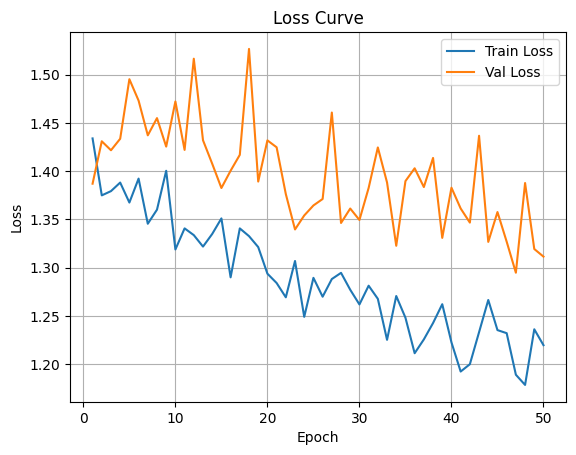

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
log_file = './logs/cls_train_log_20250705_173445.csv' 
df = pd.read_csv(log_file)

# Plot
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()



Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.98      0.66        41
           1       0.00      0.00      0.00         7
           2       0.50      0.21      0.30        28
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         6

    accuracy                           0.48        95
   macro avg       0.20      0.24      0.19        95
weighted avg       0.36      0.48      0.37        95



<Figure size 800x600 with 0 Axes>

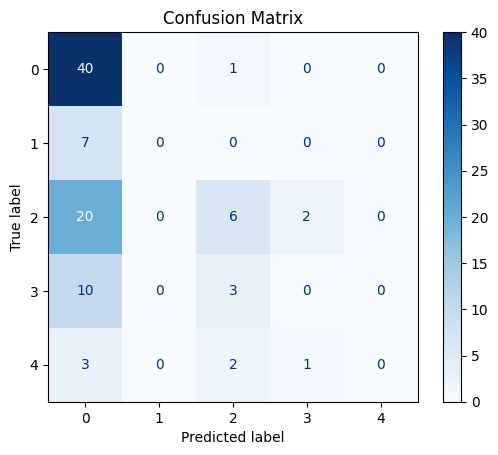

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = ResUNet(in_channels=3, num_classes=5)
model.load_state_dict(torch.load('logs/best_cls_model.pth'))
model.eval().to(device)

all_preds = []
all_labels = []


with torch.no_grad():
    for images, labels, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        cls_outputs = outputs['only_classification']
        _, preds = torch.max(cls_outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:\n", classification_report(all_labels, all_preds))


class_names = [str(i) for i in range(5)]  
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [3]:
segmentation_dir = './dataset/1. Original Images/b. Testing Set'
mask_dir = './dataset/2. All Segmentation Groundtruths/b. Testing Set'
image_dir = './classification_dataset/1. Original Images/b. Testing Set'
csv_dir = './classification_dataset/. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

dataset = IDRiD_Dataset(
    image_root=segmentation_dir,
    csv_path=csv_dir,
    mask_root=mask_dir,
    trainsize=352,
    augmentations=False,
    mask_type='multichannel'
)

test_loader = DataLoader(dataset, batch_size=4, shuffle=False)

No augmentations



Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.73      0.50        11
           1       0.00      0.00      0.00         3
           2       0.25      0.14      0.18         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3

    accuracy                           0.33        27
   macro avg       0.13      0.17      0.14        27
weighted avg       0.22      0.33      0.25        27



<Figure size 800x600 with 0 Axes>

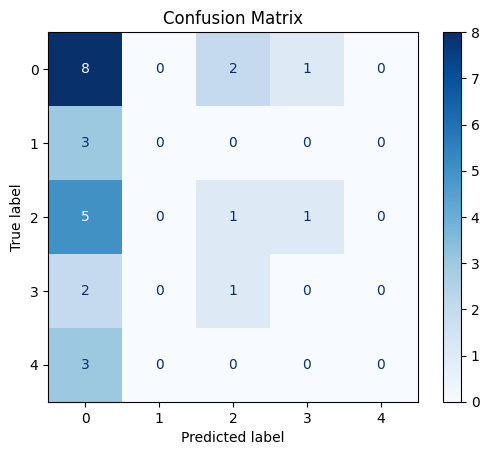

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = ResUNet(in_channels=3, num_classes=5)
model.load_state_dict(torch.load('logs/best_cls_model.pth'))
model.eval().to(device)

all_preds = []
all_labels = []


with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        cls_outputs = outputs['only_classification']
        _, preds = torch.max(cls_outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:\n", classification_report(all_labels, all_preds))


class_names = [str(i) for i in range(5)]  
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
